Things to test:
- Smaller window (2-3 coulomb peak)
  Z[50:150, 20:120]. If it has a transition, check that it still finds a transition
- Lower resolution (e.g.60x60 points, decimation)
  Z[20:120:5, 20:120:5] Adds a 5x decimation (only use every 5th)
- Add noise
  Z + alpha *np.random.uniform(Z.size) adds noise with magnitude alpha
  
Feel free to combine multiple tests

In [9]:
import qcodes as qc
import numpy as np
import math
from scipy import signal
conv2 = signal.convolve2d
peaks = signal.find_peaks
pi = math.pi

pyqtgraph plotting not supported, try "from qcodes.plots.pyqtgraph import QtPlot" to see the full error


In [10]:
qc.data.data_set.DataSet.default_io.base_location = r'/Users/Dennis/Documents/Uni/ThesisB/Jupyter/CSD'
data = qc.load_data('2018-03-26/#004_4D_DC_TGAC_DBL_DBR_14-51-19')
data

DataSet:
   location = '2018-03-26/#004_4D_DC_TGAC_DBL_DBR_14-51-19'
   <Type>   | <array_id>          | <array.name> | <array.shape>
   Setpoint | DC_control_DFR_set  | DFR          | (3,)
   Setpoint | DC_control_DFL_set  | DFL          | (3, 3)
   Setpoint | DBL_DBR_set         | DBL_DBR      | (3, 3, 301)
   Setpoint | DC_control_TGAC_set | TGAC         | (3, 3, 301, 251)
   Measured | DC_voltage          | DC_voltage   | (3, 3, 301, 251)

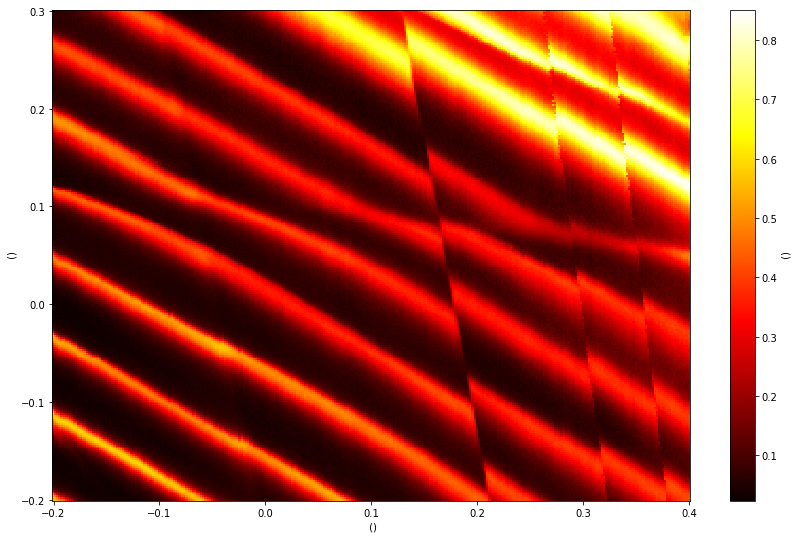

In [85]:
# importing data
x = data.DBL_DBR_set[1,1,:]
y = data.DC_control_TGAC_set[1,1,1,:]
Z = data.DC_voltage[0,2,:,:] #change these values for different datasets
#00 none 
#01 one clear
#02 three clear
#10 four clear
#11 five messy
#12 seven ok clarity. See this one for two transitions crossing clearly
#20 five messy at end
#21 six messy
#22 seven clearish
Z = np.swapaxes(Z,0,1)
plot = qc.MatPlot(Z,x=x,y=y,  figsize=(12,8))
#0.408
#0.203 #0.367 on 20 due to scanning error
#seems to work better in the centre of the image
#nonetheless, this works fully on all sample data. I hope it is not very overfitted

In [89]:
%%timeit
transitions = find_transitions(Z,x,y, trueunits=True)
transitions
#4.09s reduced normsum range
#8.16s full range

2.97 s ± 163 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


0.66530612244897969

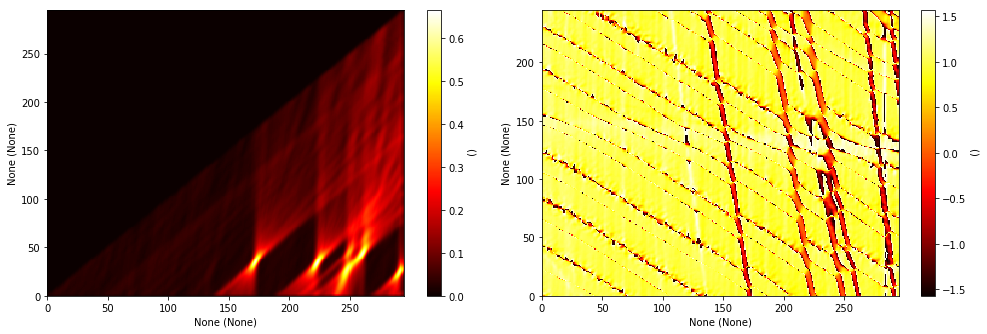

In [81]:
#use this to demonstrate how the program works
theta = calc_theta(Z, filter=True)
peak = find_mode(theta)
normsum = calc_normsum(theta, peak)
plot = qc.MatPlot(normsum, theta, figsize=(14,5))
np.max(normsum)

0.6303673469387755

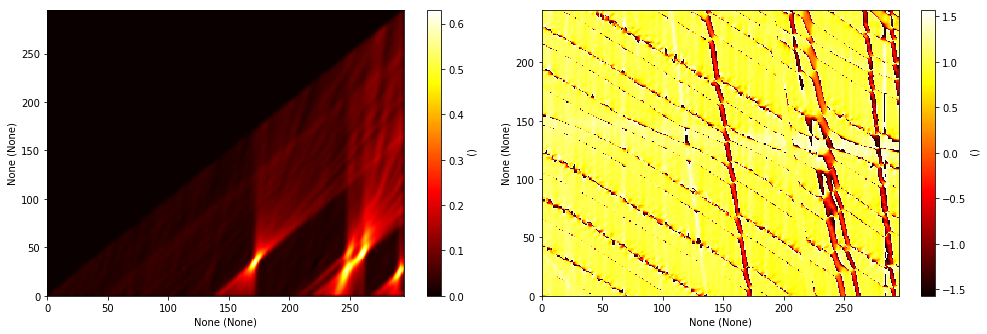

In [82]:
theta = delete_trans(normsum, theta, peak)
normsum = calc_normsum(theta, peak)
plot = qc.MatPlot(normsum, theta, figsize=(14,5))
np.max(normsum)

In [1]:
def calc_theta(Z, filter = False):
    ### Filter coefficients
    # filter for S before
    xSfil = np.array([[1], [2], [1]])
    ySfil = np.array([[1, 2, 1]])
    
    # filter for G after (not used currently)
    xGfil = np.array([[1], [2], [1]])
    yGfil = np.array([[1, 2, 1]])
    Gfil  = conv2(xGfil,yGfil)
    
    # filter for Z before (not used currently)
    #xZfil = np.array([[1], [4], [6], [4], [1]])
    #yZfil = np.array([[1, 4, 6, 4, 1]])
    xZfil = np.array([[1], [2], [1]])
    yZfil = np.array([[1, 2, 1]])
    Zfil  = conv2(xZfil,yZfil)
    
    
    # Sobel Operator
    SY = np.array([[1], [0], [-1]])
    SY = conv2(SY,ySfil)
    
    SX = np.array([[1, 0, -1]])
    SX = conv2(SX,xSfil)
    
    if(filter == True):
        Z = conv2(Z, Zfil, mode='valid')
    
    GY = conv2(Z, SY, mode='valid')
    
    GX = conv2(Z, SX, mode='valid')
    
    if(filter == True):
        GY = conv2(GY, Gfil, mode='valid')
        GX = conv2(GX, Gfil, mode='valid')
    
    #this isnt even used
    #G = (GX**2 + GY**2)**0.5;
    
    theta = np.arctan(GY/GX)
    return theta

In [83]:
def calc_normsum(theta, peak):
    # Generate Lines
    ly = theta.shape[0]
    lx = theta.shape[1]

    normsum = np.zeros((lx,lx))
    yl = np.linspace(0, ly, ly, endpoint=False, dtype=int)
    yl = yl.ravel()
    
    maxdx = np.ceil(ly/3).astype(int)

    for x1 in range(lx):
        for dx in range(min([x1+1,maxdx])):
            xl = x1 + np.around(-dx*yl/ly).astype(int);
            # Try find the most ideal function. best currently is around(cos^2)
            #normsum[dx,x1] = np.sum(np.abs(np.sin(peak-theta[yl,xl])))/ly
            #normsum[dx,x1] = 1-np.mean(np.abs(np.cos(peak-theta[yl,xl])))
            normsum[dx,x1] = 1-np.mean(np.abs(np.around(np.cos(peak-theta[yl,xl])**2)))
            
    filt = np.ones((5,5))
    normsum = conv2(normsum, filt, mode='same')/25
    return normsum

In [50]:
def find_mode(theta):
    H = np.reshape(theta,-1)
    hist, hist_edges = np.histogram(H, np.linspace(-pi, pi, 100))
    ind = max_index(hist)
    peak = (hist_edges[ind] +hist_edges[ind +np.array([1])])*0.5;
    return peak

In [51]:
def max_index(M):
    return np.unravel_index(np.argmax(M, axis=None), M.shape)

In [52]:
def delete_trans(normsum, theta, peak):
    I = max_index(normsum)
    ly = theta.shape[0]
    lx = theta.shape[1]
    
    yl = np.linspace(0, ly, ly, endpoint=False, dtype=int)
    yl = yl.ravel()
    
    #this is naive at the moment
    start = I[1]-3
    stop = I[1]+3
    dx = I[0]
    
    if(start<0):
        start = 0
    if(stop > lx): #this needs some fix
        stop = lx
    if(start-dx <0):
        dx = start
    
    for x1 in range(start,stop):
        xl = x1 + np.around(-dx*yl/ly).astype(int);
        theta[yl,xl] = peak
            
    return theta

In [53]:
def find_transitions(Z,x,y, trueunits=False):
    theta = calc_theta(Z, filter=True)
    peak = find_mode(theta)
    normsum = calc_normsum(theta, peak)
    #plot = qc.MatPlot(normsum, theta, figsize=(14,5))

    translist = []

    while(np.max(normsum)>0.4):
        
        I = max_index(normsum)
        M = np.max(normsum)
    
        difx = (x.shape[0]-theta.shape[1])/2
        dify = (y.shape[0]-theta.shape[0])/2
        location = (difx +I[1] +np.around(dify*I[0]/theta.shape[0])).astype(int)
    
        gradient = -(theta.shape[0]/I[0])
        
        #dV = ∆Vtop = ∆q/Ctop
        dV, dI = get_chargetransfer(Z, location, gradient, peak)
        
        #this peak detection could DEFINITELY be fine-tuned (check back for how dI is calculated tooooo)
        #i did it very quick sticks
        #11pm on a saturday night
        #yes, that quick
        peaks = (signal.find_peaks(dI, distance=25, height=0.2))
        yval = peaks[0]
        xval = (location + np.around(yval/gradient)).astype(int);
        dIval = peaks[1]['peak_heights']
        
        if (trueunits): #this makes all the values in actual units, not just indices
                #units in V/V
            gradient = gradient*(y[1]-y[0])/(x[1]-x[0]) #in V/V
                #units in V
            location = x[location]
                #units in V
            dV = dV*(y[1]-y[0])
                #units in V
            yval = y[yval]
                #units in V
            xval = x[xval]
        
        trans = {'location' : location, 'gradient': gradient,\
                 'intensity' : M, '∆Vtop' : dV,# '∆I' : dI,\
                 '∆I_y' : yval, '∆I_x' : xval, '∆I_val' : dIval}
        translist.append(trans)

        theta = delete_trans(normsum, theta, peak)
        normsum = calc_normsum(theta, peak)
        
        #plot = qc.MatPlot(normsum, theta, figsize=(14,5))
        
    return translist

In [13]:
def get_chargetransfer(Z, Xi, gradient, peak):
    ly = Z.shape[0]
    yl = np.linspace(0, ly, ly, endpoint=False, dtype=int)#.ravel()  #<<< check out if that works
    yl = yl.ravel()
    xl = (Xi + np.around(yl/gradient)).astype(int);
    
    try:
            #lines to check before and after
        shift = 3
        line_pre = Z[yl,xl -shift]
        line_pos = Z[yl,xl +shift]
        #average magnitude difference function
        AMDF = np.zeros(ly)
        for i in range(ly):
            #AMDF[i] = np.mean(np.abs(np.around(np.cos(peak-theta[yl,xl])**2)))
            AMDF[i] = -np.mean(np.abs(line_pre[np.array(range(0,ly-i))] -line_pos[np.array(range(i,ly))]))*(ly+i)/ly
            
        # the 7 in the following line is from the 1 +2*reach of the pos/pre lines
        #qc.MatPlot(AMDF, figsize=(14,5))
        peakshift = np.around(np.abs(np.tan(peak-np.pi/2))*(1+2*shift))[0].astype(int)
        dV = max_index(AMDF)[0] + peakshift
        
        shift = 1
        line_pre = Z[yl,xl -shift]
        line_pos = Z[yl,xl +shift]
        dI = (line_pre -line_pos)
        
        return dV, dI
    except:
        return -1,-1